# WIP: migrating into using huggingface dataset

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --------------------------------------------------------------------------- #
#                               repo helpers                                  #
# --------------------------------------------------------------------------- #
from helper import (  # noqa: E402  pylint: disable=wrong-import-position
    CLEAN_DIR,
    CSV_DIR,
    SCOPE_DIR,
    FIG_DIR,
    NAME_MAPPING,
    PREFER_ORDER,
    COLOR_MAP,
    read_json,
)

# --------------------------------------------------------------------------- #
#                              global constants                               #
# --------------------------------------------------------------------------- #
SUMMARY_LABEL = "All_Agents"           # internal key
SUMMARY_LABEL_DISPLAY = "All Agents"   # label shown in plots/tables

In [10]:

# --------------------------------------------------------------------------- #
#                               I/O helpers                                   #
# --------------------------------------------------------------------------- #
def _load_json(filename: str):
    """Load *filename* from CLEAN_DIR with prototype fallback."""
    fp = CLEAN_DIR / filename
    return read_json(fp)


def _load_real_users() -> pd.DataFrame:
    """Return dataframe mapping PR ids to real users if available."""
    fp = CSV_DIR / "real_users.csv"
    if not fp.exists():
        return pd.DataFrame(columns=["agent", "pr_id", "user"])
    return pd.read_csv(fp, dtype={"pr_id": str})


# --------------------------------------------------------------------------- #
#                              core analytics                                 #
# --------------------------------------------------------------------------- #
def _categorize(login: str, user_type: str | None, pr_user: str | None) -> str:
    norm = login.lower()
    if pr_user and norm == pr_user.lower():
        return "PR Author"
    if user_type == "Bot" or norm.endswith("[bot]"):
        return "Agent/Bot"
    if user_type == "User":
        return "Human Developer"
    return "Other"


def analyze_agent_reviews(
        agent: str,
        real_users: pd.DataFrame | None = None,
        reviews: dict[str, list] | None = None,
) -> pd.DataFrame:
    """Flatten review JSON into DataFrame."""
    if reviews is None:
        reviews = _load_json(f"{agent}_pr_reviews.json")
    if not reviews:
        return pd.DataFrame(columns=["agent", "pr_id", "reviewer", "type", "category"])

    prs = _load_json(f"{agent}_all_prs.json")
    pr_author = {str(pr.get("id")): pr.get("user", {}).get("login") for pr in prs}
    if real_users is not None and not real_users.empty:
        subset = real_users[real_users["agent"].str.lower() == agent.lower()]
        for _, row in subset.iterrows():
            pr_author[str(row["pr_id"])] = row["user"]

    rows: list[dict[str, str]] = []
    for pr_file, review_list in reviews.items():
        pr_id = pr_file.replace(".json", "")
        author = pr_author.get(pr_id)
        for review in review_list:
            login = review.get("user", {}).get("login")
            if not login:
                continue
            utype = review.get("user", {}).get("type")
            rows.append(
                {
                    "agent": agent,
                    "pr_id": pr_id,
                    "reviewer": login,
                    "type": utype,
                    "category": _categorize(login, utype, author),
                }
            )
    return pd.DataFrame(rows)


def summarize_prs(
        agent: str, reviews: dict[str, list], reviews_df: pd.DataFrame
) -> pd.DataFrame:
    """Return PR-level classification flags."""
    rows = []
    for pr_file in reviews.keys():
        pr_id = pr_file.replace(".json", "")
        sub = reviews_df[reviews_df["pr_id"] == pr_id]
        has_h = np.logical_or(
            sub["category"] == "Human Developer", sub["category"] == "PR Author"
        ).any()
        has_a = (sub["category"] == "Agent/Bot").any()
        if has_h and not has_a:
            cls = "only_human"
        elif has_a and not has_h:
            cls = "only_bot"
        elif has_h and has_a:
            cls = "both"
        else:
            cls = "none"
        rows.append(
            {
                "agent": agent,
                "pr_id": pr_id,
                "has_human": has_h,
                "has_agent": has_a,
                "classification": cls,
            }
        )
    return pd.DataFrame(rows)


def build_popular_agent_bot_table(
        agent_bot_counts: dict[str, pd.Series],
        agent_total_bot_reviews: dict[str, int],
        top_n: int = 10,
) -> pd.DataFrame:
    """Return MultiIndex column table of raw counts and %."""
    df_counts = pd.DataFrame(agent_bot_counts).fillna(0).astype(int)
    df_perc = df_counts.div(pd.Series(agent_total_bot_reviews), axis=1) * 100

    top_reviewers = df_counts.sum(axis=1).nlargest(top_n).index
    df_counts, df_perc = df_counts.loc[top_reviewers], df_perc.loc[top_reviewers]

    agents = df_counts.columns.tolist()
    cols = [(a, "Count") for a in agents] + [(a, "\\%") for a in agents]
    combo = pd.DataFrame(index=top_reviewers, columns=pd.MultiIndex.from_tuples(cols))
    for a in agents:
        combo[(a, "Count")] = df_counts[a]
        combo[(a, "\\%")] = df_perc[a].round(1)
    combo.index.name = "Reviewer"
    return combo


# --------------------------------------------------------------------------- #
#                               visualisation                                 #
# --------------------------------------------------------------------------- #
def _best_text_color(bg_hex: str) -> str:
    """Return 'white' or 'black' depending on background luminance."""
    bg_hex = bg_hex.lstrip("#")
    r, g, b = tuple(int(bg_hex[i:i+2], 16) for i in (0, 2, 4))
    luminance = (0.299 * r + 0.587 * g + 0.114 * b) / 255
    return "black" if luminance > 0.5 else "white"


def plot_classification_stacked(df: pd.DataFrame) -> None:
    """Horizontal 100 % stacked bars with in-bar percentages and separator line."""
    special_agents = [a for a in ["Human", SUMMARY_LABEL] if a in df.index]
    other_agents = df.index.difference(special_agents)
    sorted_agents = (
        df.loc[other_agents].sort_values("only_human", ascending=False).index.tolist()
    )
    order = special_agents + sorted_agents
    df = df.loc[order, ["only_human", "only_bot", "both", "none"]]

    labels = {
        "only_human": "Only Human",
        "only_bot": "Only Bot",
        "both": "Human + Bot",
        "none": "No Reviews",
    }
    colors = {
        "only_human": COLOR_MAP["Copilot"],
        "only_bot": COLOR_MAP["Claude_Code"],
        "both": COLOR_MAP.get("Devin", "#009E73"),
        "none": "#999999",
    }

    ylabels = [
        NAME_MAPPING.get(a, SUMMARY_LABEL_DISPLAY if a == SUMMARY_LABEL else a).replace(
            "_", " "
        )
        for a in df.index.to_list()
    ]
    fig, ax = plt.subplots(figsize=(8, 4))
    left = pd.Series([0] * len(df), index=df.index)

    # Draw bars
    for col in ["only_human", "both", "only_bot", "none"]:
        ax.barh(
            ylabels,
            df[col],
            left=left,
            color=colors[col],
            label=labels[col],
            height=0.6,
        )
        left += df[col]

    # Annotate percentages in-bar
    for row_idx, agent in enumerate(df.index):
        cum_x = 0.0
        for col in ["only_human", "both", "only_bot", "none"]:
            width = df.loc[agent, col]
            if width <= 0:
                continue
            x_center = cum_x + width / 2
            width = round(width, 1)
            pct_txt = f"{width:.1f}"
            text_color = _best_text_color(colors[col])
            ax.text(
                x_center,
                row_idx,
                pct_txt,
                ha="center",
                va="center",
                fontsize=8,
                color=text_color,
            )
            cum_x += width

    # Axes, legend, separator
    ax.set_xlabel("Share of PRs (%)")
    ax.set_xlim(0, 100)
    ax.invert_yaxis()
    ax.legend(title="Reviewer Type", loc="upper right", ncol=1, frameon=True)

    sep_y = len(special_agents) - 0.5
    ax.axhline(sep_y, color="black", linewidth=1.2, linestyle="--")

    fig.tight_layout()
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out_fp = FIG_DIR / "reviewer_classification_stacked.pdf"
    fig.savefig(out_fp, dpi=300)
    fig.savefig(out_fp.with_suffix(".png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Wrote", out_fp)

def plot_bot_heatmap(popular_df: pd.DataFrame) -> None:
    """Percentage heat-map with manual row/column ordering for interpretability."""
    if popular_df.empty:
        return

    perc = popular_df.xs("\\%", level=1, axis=1).astype(float)

    # --- Step 1: MANUAL ordering ---
    manual_column_order = [
        "Human",
        "OpenAI_Codex",
        "Claude_Code",
        "Cursor",
        "Devin",
        "Copilot",
    ]
    manual_row_order = [
        "copilot-swe-agent[bot]",
        "cursor[bot]",
        "gemini-code-assist[bot]",
        "copilot-pull-request-reviewer[bot]",
        "coderabbitai[bot]",
        "ellipsis-dev[bot]",
        "greptile-apps[bot]",
        "entelligence-ai-pr-reviews[bot]",
        "Copilot",
        "github-advanced-security[bot]",
    ]

    # --- Step 2: Apply order ---
    # Filter for rows/columns that actually exist
    manual_column_order = [c for c in manual_column_order if c in perc.columns]
    manual_row_order = [r for r in manual_row_order if r in perc.index]

    perc = perc.loc[manual_row_order, manual_column_order]

    # Optional: pretty names
    perc.columns = [NAME_MAPPING.get(c, c).replace("_", " ") for c in perc.columns]

    # --- Step 3: Plot ---
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        perc,
        annot=True,
        fmt=".1f",
        cmap="Blues",
        ax=ax,
        cbar_kws={"label": "Share of Bot Reviews (%)"},
        vmin=0,
        vmax=100,
    )

    ax.tick_params(axis="both", length=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel("Reviewer Bot")

    fig.tight_layout()
    FIG_DIR.mkdir(parents=True, exist_ok=True)
    out_fp = FIG_DIR / "bot_heatmap.pdf"
    fig.savefig(out_fp, dpi=300, bbox_inches="tight")
    fig.savefig(out_fp.with_suffix(".png"), dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print("Wrote", out_fp)


In [11]:

# --------------------------------------------------------------------------- #
#                                    main                                     #
# --------------------------------------------------------------------------- #
def main() -> None:
    USE_SCOPE = True
    CSV_DIR.mkdir(exist_ok=True)
    real_users = _load_real_users()

    # --------------- gather sources ---------------- #
    sources: list[tuple[str, dict[str, list]]] = []
    if USE_SCOPE:
        for subdir in SCOPE_DIR.iterdir():
            if not subdir.is_dir():
                continue
            agent = subdir.name
            fp = subdir / "pr_reviews.json"
            if fp.exists():
                sources.append((agent, read_json(fp)))
            else:
                print(f"[scope] no pr_reviews.json for {agent}, skipping")

    # --------------- processing -------------------- #
    all_summaries = []
    overall_counts = {"only_human": 0, "only_bot": 0, "both": 0, "none": 0}
    overall_total = 0
    agent_bot_counts: dict[str, pd.Series] = {}
    agent_total_bot_reviews: dict[str, int] = {}

    for agent, reviews in sources:
        reviews_df = analyze_agent_reviews(agent, real_users, reviews)
        if reviews_df.empty and all(len(lst) == 0 for lst in reviews.values()):
            print(f"[skip] no reviews data for {agent}")
            continue

        pr_summary = summarize_prs(agent, reviews, reviews_df)
        pr_summary.to_csv(CSV_DIR / f"{agent}_pr_summary.csv", index=False)

        bot_only = reviews_df[reviews_df["category"] == "Agent/Bot"]
        counts = bot_only["reviewer"].value_counts()
        agent_bot_counts[agent] = counts
        agent_total_bot_reviews[agent] = len(bot_only)

        total = len(pr_summary)
        vc = pr_summary["classification"].value_counts().to_dict()
        all_summaries.append(
            {
                "agent": agent,
                "only_human": vc.get("only_human", 0) / total * 100,
                "only_bot": vc.get("only_bot", 0) / total * 100,
                "both": vc.get("both", 0) / total * 100,
                "none": vc.get("none", 0) / total * 100,
            }
        )
        if agent != "Human":
            for key in overall_counts:
                overall_counts[key] += vc.get(key, 0)
            overall_total += total

    if overall_total > 0:
        all_summaries.append(
            {
                "agent": SUMMARY_LABEL,
                "only_human": overall_counts["only_human"] / overall_total * 100,
                "only_bot": overall_counts["only_bot"] / overall_total * 100,
                "both": overall_counts["both"] / overall_total * 100,
                "none": overall_counts["none"] / overall_total * 100,
            }
        )

    if not all_summaries:
        print("No review data found.")
        return

    summary_df = pd.DataFrame(all_summaries).set_index("agent")

    print(
        summary_df.to_latex(
            float_format="%.1f",
            caption=(
                "Percentage breakdown of reviewer types for each coding agent."
            ),
            escape=False,
            na_rep="--",
            multicolumn=True,
            multicolumn_format="c",
            index_names=True,
        )
    )

    summary_df.to_csv(CSV_DIR / "agent_pr_reviewer_classification_percentages.csv")

    popular_df = build_popular_agent_bot_table(agent_bot_counts, agent_total_bot_reviews)

    plot_classification_stacked(summary_df)
    plot_bot_heatmap(popular_df)

\begin{table}
\caption{Percentage breakdown of reviewer types for each coding agent.}
\begin{tabular}{lrrrr}
\toprule
 & only_human & only_bot & both & none \\
agent &  &  &  &  \\
\midrule
Cursor & 32.6 & 18.1 & 6.9 & 42.4 \\
Claude_Code & 23.8 & 12.9 & 9.9 & 53.5 \\
Human & 14.7 & 6.4 & 3.6 & 75.3 \\
OpenAI_Codex & 12.8 & 15.0 & 5.4 & 66.8 \\
Copilot & 15.7 & 2.9 & 37.4 & 44.0 \\
Devin & 33.2 & 6.1 & 2.5 & 58.3 \\
All_Agents & 21.8 & 9.1 & 11.0 & 58.2 \\
\bottomrule
\end{tabular}
\end{table}


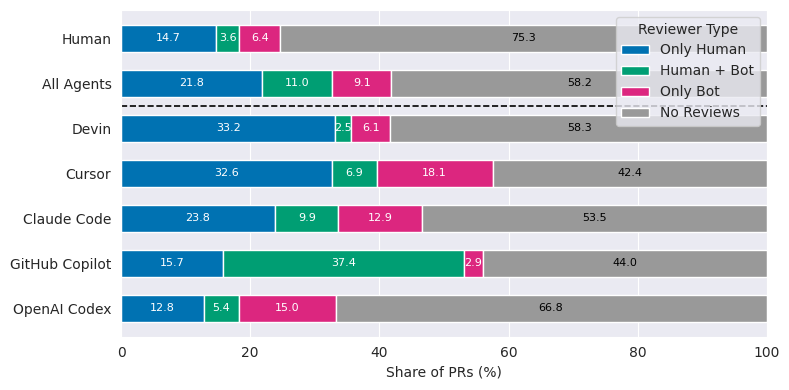

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/reviewer_classification_stacked.pdf


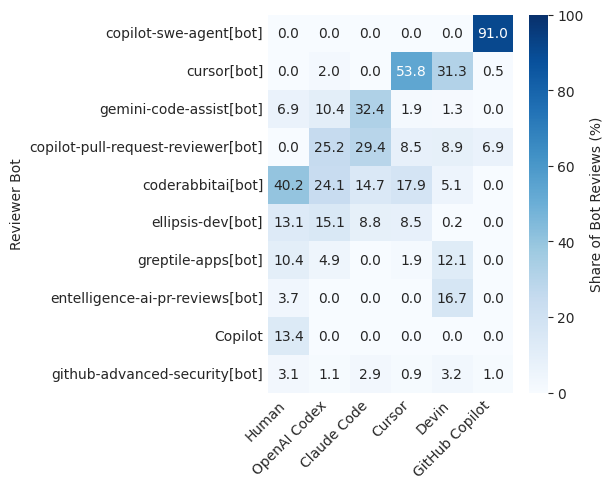

Wrote /home/leo/Projects/replication_package/AI_Teammates_in_SE3/figs/bot_heatmap.pdf


In [12]:
main()